# Car Detection using YOLO model

## YOLO
"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

---

## Model details

### Encoding
If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

<img src="images/architecture.png" style="width:700px;height:400;">
<caption><center> Encoding architecture for YOLO<br> </center></caption>

### Class Score

Now, for each of the **5 anchor boxes (of each cell from 19x19 grid)**, we compute the class score as $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="images/probability_extraction.png" style="width:700px;height:400;">

### Visualizing Classes

* Method 1 - for each of the 19x19 grid cells, find the class with maximum probability scores (across 5 anchor boxes, and use that to color the cell
* Method 2 - plot the bounding boxes that it outputs.

<div class="row">
  <div style="float:left;margin-right:5px;">
        <img src="images/proba_map.png" height="300" width="300"  />
        <p style="text-align:center;">Method 1</p>
    </div>
    <div style="float:left;margin-right:5px;">
        <img class="middle-img" src="images/anchor_map.png" height="200" width="200" />
        <p style="text-align:center;">Method 2</p>
    </div>
</div>

### Non-max Suppression
* Get rid of boxes with a low score. Meaning, the box is not very confident about detecting a class, either due to the low probability of any object, or low probability of this particular class.
* Select only one box when several boxes overlap with each other and detect the same object.

<img src="images/non-max-suppression.png" style="width:500px;height:300;">

**Intersection over Union (IoU)**:
<img src="images/iou.png" style="width:500px;height:400;">

Recall that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) is the lower-right corner. As x increases, you move to the right.  As y increases, you move down.


### Dimensions
* IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85) -> Flatten last two dims (m, 19, 19, 425)
  * 5 anchor boxes selected by exploring training data to choose height/width ratios that represent different classes
  * 85 = 80 possible classes + $(p_c, b_x, b_y, b_h, b_w)$
* For simplicity, we define:
  - `box_confidence`: $(19, 19, 5, 1)$ tensor containing $p_c$ (probability that there's some object) for each of the 5 boxes
  - `boxes`: $(19, 19, 5, 4)$ tensor containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes
  - `box_class_probs`: $(19, 19, 5, 80)$ tensor containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes
 
---

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

## Helper Functions
* `yolo_filter_boxes` - finds the class with max probability for each box + filters those below a certain threshold
* `yolo_non_max_suppression` - removes overlapping boxes
* `yolo_boxes_to_corners` - converts box cordinates from (x,y,w,h) to (x1, y1, x2, y2)
* `scale_boxes` - scale box to image size
* `preprocess_image`, `get_colors_for_classes`,`draw_boxes`, `yolo_head` - drawing model output on image

**References** - 
* [tf.math.argmax](https://www.tensorflow.org/api_docs/python/tf/math/argmax), [tf.math.reduce_max](https://www.tensorflow.org/api_docs/python/tf/math/reduce_max), [tf.boolean mask](https://www.tensorflow.org/api_docs/python/tf/boolean_mask)  

* [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression), [tf.gather()](https://www.tensorflow.org/api_docs/python/tf/gather)

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- only keep boxes with [highest class probability score > threshold]

    Returns:
        scores -- tensor of shape (None,), class probability score for selected boxes
        boxes -- tensor of shape (None, 4), (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), index of the class detected by the selected boxes

    Note: "None" is here because we don't know the exact number of selected boxes, as it depends
    on the threshold. E.g. if there are 10 boxes, the output size of scores would be (10,).
    """
    
    # Compute box-size - score for each class = p*ci
    box_scores = box_confidence * box_class_probs          # (19, 19, 5, 80)

    # Find the class with maximum score for each box
    box_classes = tf.math.argmax(box_scores, axis=-1)      # -1 = last dimension, or 3
    box_class_scores = tf.reduce_max(box_scores, axis=-1)  # max value, collapses dim
    
    # Create a filtering mask (same dimension as box_class_scores)
    filtering_mask = box_class_scores > threshold
    
    # Apply the mask to box_class_scores, boxes and box_classes
    scores  = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes   = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)

    return scores, boxes, classes

In [3]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Returns: "None" <= max_boxes
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note also that this function will transpose the shapes of scores, boxes, classes.
    This is made for convenience.
    """
    
    # tensor to be used in tf.image.non_max_suppression()
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')

    # Get the list of indices corresponding to boxes to keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    
    # tf.gather() to select only nms_indices from scores, boxes and classes
    scores  = tf.gather(scores, nms_indices)
    boxes   = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
   
    return scores, boxes, classes

In [4]:
# Converts box coordinates from (x,y,w,h) to corners coordinates (x1, y1, x2, y2)
def yolo_boxes_to_corners(box_xy, box_wh):
       
    box_mins  = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2], # y_max
        box_maxes[..., 0:1]  # x_max
    ])

# Scale box (x, y) to image size - in order to be drawable on the image
def scale_boxes(boxes, image_shape):
    h, w = float(image_shape[0]), float(image_shape[1])
    image_dims = K.stack([h, w, h, w])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

In [5]:
import imghdr
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

In [6]:
import colorsys, random
def get_colors_for_classes(num_classes):
    """Return list of random colors for number of classes given."""
    # Use previously generated colors if num_classes is the same.
    if (hasattr(get_colors_for_classes, "colors") and
            len(get_colors_for_classes.colors) == num_classes):
        return get_colors_for_classes.colors

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    random.seed(10101)                      # Fixed seed for consistent colors across runs.
    random.shuffle(colors)                  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)                       # Reset seed to default.
    get_colors_for_classes.colors = colors  # Save colors for future calls.
    return colors

In [7]:
from PIL import ImageFont, Image, ImageDraw
def draw_boxes(image, boxes, box_classes, class_names, scores=None):
    """Draw bounding boxes on image.
    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indices into `class_names`.
        class_names: A `list` of `string` class names.
        `scores`: A `list` of scores for each box.
    Returns:
        A copy of `image` modified with given bounding boxes.
    """
    font = ImageFont.truetype(font='data/detection_yolo/font/FiraMono-Medium.otf',
                              size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        
        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            label = '{} {:.2f}'.format(box_class, score)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top    = max(0, np.floor(top + 0.5).astype('int32'))
        left   = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right  = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)

In [8]:
def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor, Final convolutional layer features.
    anchors : array-like, Anchor box widths and heights.
    num_classes : int, Number of target classes.

    Returns
    -------
    box_xy : tensor; x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor; w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor; Probability estimate for whether each box contains any object.
    box_class_pred : tensor; Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs

---
## Pre-trained YOLO model

In [9]:
# Read 80 class names & 5 anchors boxes
with open("data/detection_yolo/coco_classes.txt") as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

with open("data/detection_yolo/yolo_anchors.txt") as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

model_image_size = (608, 608) # Same as yolo_model input layer size

In [10]:
class_names[:5], anchors

(['person', 'bicycle', 'car', 'motorbike', 'aeroplane'],
 array([[0.57273 , 0.677385],
        [1.87446 , 2.06253 ],
        [3.33843 , 5.47434 ],
        [7.88282 , 3.52778 ],
        [9.77052 , 9.16828 ]]))

In [11]:
yolo_model = load_model("pretrainedmodel/", compile=False)

C:\Users\uditg\anaconda3\lib\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [12]:
# This model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) 
# into a tensor of shape (m, 19, 19, 5, 85).

yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 38, 38, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 38, 38, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 38, 38, 256)  131072      ['leaky_re_lu_8[0][0]']          
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 38, 38, 256)  1024       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

 conv2d_20 (Conv2D)             (None, 38, 38, 64)   32768       ['leaky_re_lu_12[0][0]']         
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 19, 19, 1024  0           ['batch_normalization_18[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 38, 38, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 19, 19, 1024  9437184     ['leaky_re_lu_18[0][0]']         
                                )                                                                 
          

## Predicting from YOLO model
---

In [13]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs # Output from YOLO model
    boxes = yolo_boxes_to_corners(box_xy, box_wh)                  # Convert boxes to corner-cordinates
    scores, boxes, classes = yolo_filter_boxes(boxes,              # Perform score filtering
                                               box_confidence, 
                                               box_class_probs, 
                                               score_threshold)
    boxes = scale_boxes(boxes, image_shape)                        # Scale boxes back to original image shape
    scores, boxes, classes = yolo_non_max_suppression(scores,      # Non-max suppression 
                                                      boxes, classes)
    return scores, boxes, classes

In [14]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """
    
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608)) # Process image
    yolo_model_outputs = yolo_model(image_data)                                                 # Model output
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))                     # returns box_xy, box_wh, 
                                                                                                # box_confidence, box_class_probs
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file)) # Print predictions info
    
    colors = get_colors_for_classes(len(class_names))                   # Generate colors for drawing bounding boxes
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)  # Draw bounding boxes on the image file
    image.save(os.path.join("output", image_file), quality=100)         # Save the predicted bounding box on the image
    output_image = Image.open(os.path.join("output", image_file))       # Display the results in the notebook
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/detection1.jpg
car 0.89 (367, 300) (745, 648)
car 0.80 (761, 282) (942, 412)
car 0.74 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 705)
bus 0.67 (5, 266) (220, 407)
car 0.66 (706, 279) (786, 350)
car 0.60 (925, 285) (1045, 374)
car 0.44 (336, 296) (378, 335)
car 0.37 (965, 273) (1022, 292)
traffic light 0.36 (681, 195) (692, 214)


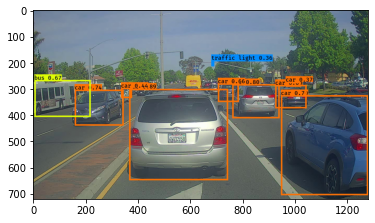

In [15]:
predict("detection1.jpg");

Found 6 boxes for images/detection2.jpg
bus 0.74 (0, 286) (203, 420)
bus 0.54 (341, 276) (414, 369)
traffic light 0.51 (388, 137) (405, 179)
car 0.51 (230, 330) (295, 381)
traffic light 0.43 (537, 129) (559, 159)
traffic light 0.42 (771, 230) (785, 248)


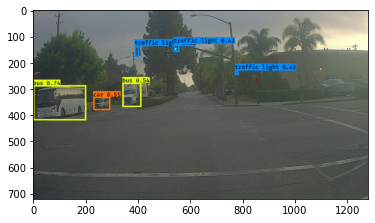

In [16]:
predict("detection2.jpg");

## Review

In [17]:
# preprocess image
image_file = "detection1.jpg"
image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
image_data.shape

(1, 608, 608, 3)

In [18]:
# model output
yolo_model_outputs = yolo_model(image_data)
yolo_model_outputs.shape

TensorShape([1, 19, 19, 425])

In [19]:
# convert model output to - box_xy, box_wh, box_confidence, box_class_probs
yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
yolo_outputs[0].shape, yolo_outputs[1].shape, yolo_outputs[2].shape, yolo_outputs[3].shape

(TensorShape([1, 19, 19, 5, 2]),
 TensorShape([1, 19, 19, 5, 2]),
 TensorShape([1, 19, 19, 5, 1]),
 TensorShape([1, 19, 19, 5, 80]))

In [20]:
# run filtering & nms to get final boxes
out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
out_scores.shape,  out_boxes.shape, out_classes.shape

(TensorShape([10]), TensorShape([10, 4]), TensorShape([10]))

In [46]:
[class_names[i] for i in out_classes.numpy()]

['car',
 'car',
 'car',
 'car',
 'bus',
 'car',
 'car',
 'car',
 'car',
 'traffic light']

In [52]:
out_scores.numpy()[5], out_boxes[4].numpy() # bus

(0.66484314,
 array([266.24033 ,   4.542246, 407.19052 , 220.25299 ], dtype=float32))

In [21]:
# get colors (1 for each class)
colors = get_colors_for_classes(len(class_names))
type(colors), len(colors), colors[:3]

(list, 80, [(255, 38, 0), (0, 63, 255), (255, 114, 0)])

car 0.89 (367, 300) (745, 648)
car 0.80 (761, 282) (942, 412)
car 0.74 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 705)
bus 0.67 (5, 266) (220, 407)
car 0.66 (706, 279) (786, 350)
car 0.60 (925, 285) (1045, 374)
car 0.44 (336, 296) (378, 335)
car 0.37 (965, 273) (1022, 292)
traffic light 0.36 (681, 195) (692, 214)


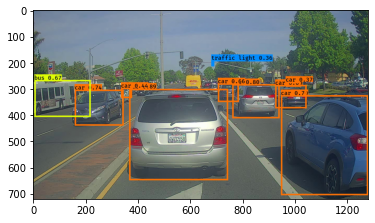

In [22]:
# draw on image & prints labels
draw_boxes(image, out_boxes, out_classes, class_names, out_scores);
imshow(Image.open(os.path.join("output", image_file)));

The end